## Library 호출 및 path 설정

## 예외 처리

In [281]:
import pandas as pd
import numpy as np
import json
import requests
import unicodedata
from copy import deepcopy

path = "https://raw.githubusercontent.com/Algorithm-Coding-Test-Data-Analysis/algoview/main/dataAnalysis/macro/data.json"                
resp = requests.get(path)

In [282]:
def unicode_err(df):  # 회사명, 문제유형, 문제이름 중복 오류
    
    '''
    unicodedata.normalize() 함수는 문자열에 있는 유니코드 문자를 
    NFKC형식(문자열을 표준 호환성(KC) 형식으로 정규화)으로 정규화합니다.
    problem_name, problem_type, company_name 컬럼의 값 중 같은 값을 
    파이썬에서 다르게 인식하는 문제를 해결합니다.
    
    Args:
        data : (DataFrame | Series)

    Returns:
        data : (DataFrame | Series)
    '''
    
    df["company_name"] = df['company_name'].apply(lambda x: unicodedata.normalize('NFKC', x))
    df["problem_type"] = df['problem_type'].apply(lambda x: unicodedata.normalize('NFKC', x))
    return df

def prob_type_to_etc(value):  # 문제 유형이 아닌 카테고리를 "기타"로 분류
    
    '''
    오류로 인해 실제 문제 유형이 아닌 값들을 예외 처리
    추후 추가 혹은 삭제 될 수 있습니다.
    
    Args:
        data : (DataFrame | Series)

    Returns:
        data : (DataFrame | Series)
    '''
    
    err_lst = ['하은.js', '문자열과', '별찍기', '개수', '다이나믹', '준혁.js', 
               '에라토스테네스의체', '수정.js' ,'지현.js', '출력하기', '회전시키기', 
               '판별하기', '반복', '반복해서', '바꿔서', '돌리기', '숫자의', '구하기']
    if value in err_lst:
        return "기타"
    else:
        return value
    
    
def file_name_exception(json_file):
    err_lst = ["Lv1_프로그래머스_행렬의덧셈_구현_지현.js",  # 1차 cycle 예외 처리 (파일명 오류, 개선 될 예정)
               "Lv0_0000_뒤에서 5등까지_구현_수정.js",
               "Lv0_0000_특정 문자열로 끝나는 가장 긴 부분 문자열 찾기_구현_수정.js",
               "Lv0_0000_자릿수더하기_구현_지현.js",
               "Lv1_0000_프로그래머스_수박수박수박수박수박수__구현_재호.py",
               "Lv1_0000_프로그래머스_3진법 뒤집기_구현_재영.py"
              ]

    print("예외 처리 전 json 파일 길이: ", len(json_file))
    for error_file in err_lst:  # 1차 cycle 예외 처리 (파일명 오류, 개선 될 예정)
        del json_file[error_file]
    print("예외 처리 후 json 파일 길이: ", len(json_file))
    
    return json_file


## DataFrame으로 변환

In [283]:
def split_data_into_py_js(data, lang = "py"):  # Python, JavaScript로 data 분리
    
    '''
    전체 데이터인 DataFrame을 입력 받아
    Pytho과 JavaScript 별로 데이터를 분리

    Args:
        data (DataFrame): DataFrame으로 변환된 data
        language  (str): 언어 구분

    Returns:
        언어별 데이터 (DataFrame)
    '''
    
    print("-"*5, "split into python DataFrame & js DataFrame","-"*5)
    
    df = data.copy()
    if lang == "py":
        py_df = df[df["file_name"].str.contains(".py")].reset_index(drop = True)
        print("python DataFrame 길이: {0}".format(len(py_df)))
        return py_df
    
    elif lang == "js":
        js_df = df[df["file_name"].str.contains(".js")].reset_index(drop = True)
        print("js DataFrame 길이: {0}".format(len(js_df)))
        return js_df

##-----------------------------------------------------------------------------------------------------------------
    
def json_to_df(json_file):  # json_normalize 사용 불가, 따라서 methodcount 와 method명을 분리하기 위함
    
    '''
    json 형태인 데이터를 입력 받아
    DataFrame으로 변환
    ‘function_method’ column 안에 method 와 module이 함께 집계됩니다.

    Args:
        data : (json)

    Returns:
        data : (DataFrame)
    '''
    
    data_json = deepcopy(json_file)
    df = pd.DataFrame() # empty DataFrame
    for file_name in data_json.keys():
        tmp_df = pd.DataFrame(data_json[file_name])
        tmp_df = tmp_df.reset_index()
        df = pd.concat([df, tmp_df], axis = 0) 

        tmp_df_len = len(tmp_df)  # countmethod가 0인 파일 사전 처리 후 concat
        if tmp_df_len == 0:
            tmp_df = pd.DataFrame(data_json[file_name], index = [0]).reset_index()
            df = pd.concat([df, tmp_df], axis = 0)
            
    df = df.reset_index(drop = True).rename(columns = {"index" : "function_method"})  # method명 column으로 변환
    df = df[['file_name', 'level', 'year', 'company_name','problem_name', 'problem_type',  # column 순서 재배치
             'function_method', 'countmethod', 'module', 'line_count', 'code']]

    df = df.fillna(np.nan)
    df = unicode_err(df) # 회사명, 문제유형, 문제이름 중복 오류
    df["problem_type"] = df["problem_type"].apply(lambda x: prob_type_to_etc(x))  # 문제 유형이 아닌 카테고리를 "기타"로 분류
    df["company_name"] = df["company_name"].apply(lambda x: prob_type_to_etc(x))  # 문제 유형이 아닌 카테고리를 "기타"로 분류
    
    return df

##-----------------------------------------------------------------------------------------------------------------


def json_to_df_split_module_method(json_file):  # module, method 별도의 column으로 분리
        
    '''
    json 형태인 데이터를 입력 받아
    DataFrame으로 변환
    module 과 method를 별도의 column으로 분리
    
    Args:
        data : (json)

    Returns:
        data : (DataFrame)
    '''
    
    data = deepcopy(json_file)
    data_2 = deepcopy(json_file)
    
    for key in data.keys():
        del data[key]["module"]
    for key in data_2.keys():
        del data_2[key]["countmethod"]

    method_df = pd.DataFrame()
    for key in data.keys():
        if data[key]["countmethod"] == 0:
            data[key]["countmethod"] = {}
        tmp_df = pd.DataFrame(data[key]).reset_index()
        tmp_df = tmp_df.rename(columns = {"index":"method"})
        method_df = pd.concat([method_df, tmp_df], axis = 0) 
    del tmp_df

    module_df = pd.DataFrame()
    for key in data_2.keys():
        tmp_df = pd.DataFrame(data_2[key]).reset_index()
        tmp_df = tmp_df.rename(columns = {"index":"module_name"})
        module_df = pd.concat([module_df, tmp_df], axis = 0)
        module_df = module_df.drop(module_df.columns.to_list()[2:], axis = 1)
    
    
    df = method_df.merge(module_df, on = "file_name", how = "left")
    df = df[['file_name', 'level', 'year', 'company_name', 'problem_name',  # column 순서 재배치
             'problem_type', 'method',  'countmethod', 'module_name', 'line_count', 'code']]
    
    df = df.fillna(np.nan)
    df = unicode_err(df)  # 회사명, 문제유형, 문제이름 중복 오류
    df["problem_type"] = df["problem_type"].apply(lambda x: prob_type_to_etc(x))  # 문제 유형이 아닌 카테고리를 "기타"로 분류
    df["company_name"] = df["company_name"].apply(lambda x: prob_type_to_etc(x))  # 문제 유형이 아닌 카테고리를 "기타"로 분류

    return df


##-----------------------------------------------------------------------------------------------------------------

def json_to_df_dict():

    df = pd.read_json(path)
    df = df.T.reset_index(drop = True)
    df = df.fillna(np.nan)
    df = unicode_err(df)
    df["problem_type"] = df["problem_type"].apply(lambda x: prob_type_to_etc(x))  # 문제 유형이 아닌 카테고리를 "기타"로 분류
    df["company_name"] = df["company_name"].apply(lambda x: prob_type_to_etc(x))  # 문제 유형이 아닌 카테고리를 "기타"로 분류
    
    return df 


In [284]:
dj = json.loads(resp.text)
dj = file_name_exception(dj)
df = json_to_df(dj)
pytho_df = split_data_into_py_js(df, "py")
javas_df = split_data_into_py_js(df, "js")

예외 처리 전 json 파일 길이:  604
예외 처리 후 json 파일 길이:  598
----- split into python DataFrame & js DataFrame -----
python DataFrame 길이: 557
----- split into python DataFrame & js DataFrame -----
js DataFrame 길이: 832


In [213]:
pd.DataFrame(data_json["Lv0_0000_프로그래머스_n의배수_구현_윤정.js"])

,file_name,level,year,company_name,problem_name,problem_type,countmethod,line_count,module,code


In [227]:
data_json[ 'Lv0_0000_프로그래머스_두 수의 연산값 비교하기_구현_예지.js']

{'file_name': 'Lv0_0000_프로그래머스_두 수의 연산값 비교하기_구현_예지.js',
 'level': 'level0',
 'year': '0000',
 'company_name': '프로그래머스',
 'problem_name': '두 수의 연산값 비교하기',
 'problem_type': '구현',
 'countmethod': 0,
 'line_count': 6,
 'module': {},
 'code': 'function solution(a, b) {\n    const atob = String(a) + String(b)\n    const ab2 = 2*a*b\n    \n    return atob >= ab2 ? Number(atob) : Number(ab2)\n}\n'}

In [237]:
a = {'file_name': 'Lv0_0000_프로그래머스_두 수의 연산값 비교하기_구현_예지.js',
 'level': 'level0',
 'year': '0000',
 'company_name': '프로그래머스',
 'problem_name': '두 수의 연산값 비교하기',
 'problem_type': '구현',
 'countmethod': {},
 'line_count': 6,
 'module': {},
 'code': 'function solution(a, b) {\n    const atob = String(a) + String(b)\n    const ab2 = 2*a*b\n    \n    return atob >= ab2 ? Number(atob) : Number(ab2)\n}\n'}

# pd.DataFrame.from_dict(a, orient= "columns")
pd.DataFrame(a)

,file_name,level,year,company_name,problem_name,problem_type,countmethod,line_count,module,code


In [241]:
## 예외처리 코드
# data_json2 = deepcopy(dj)
# df = pd.DataFrame() # empty DataFrame
# i = 0
# lst = []
# for file_name in data_json2.keys():
#     i += 1
#     tmp_df = pd.DataFrame(data_json2[file_name])
#     tmp_df = tmp_df.reset_index()
    
#     tmp_df_len = len(tmp_df)
#     df_len = len(df)
    
#     df = pd.concat([df, tmp_df], axis = 0)
#     if tmp_df_len == 0:
#         tmp_df = pd.DataFrame(data_json2[file_name], index = [0]).reset_indext()
#         df = pd.concat([df, tmp_df], axis = 0)


        
#     print("len(df): {0}, tmp_df_len: {1} + df_len: {2}: {3}, i:{4}".format(len(df), tmp_df_len, df_len,  len(df) ==(tmp_df_len + df_len), i))


len(df): 2, tmp_df_len: 2 + df_len: 0: True, i:1
len(df): 5, tmp_df_len: 3 + df_len: 2: True, i:2
len(df): 9, tmp_df_len: 4 + df_len: 5: True, i:3
len(df): 11, tmp_df_len: 2 + df_len: 9: True, i:4
len(df): 12, tmp_df_len: 1 + df_len: 11: True, i:5
len(df): 14, tmp_df_len: 2 + df_len: 12: True, i:6
len(df): 17, tmp_df_len: 3 + df_len: 14: True, i:7
len(df): 20, tmp_df_len: 3 + df_len: 17: True, i:8
len(df): 23, tmp_df_len: 3 + df_len: 20: True, i:9
len(df): 27, tmp_df_len: 4 + df_len: 23: True, i:10
len(df): 28, tmp_df_len: 1 + df_len: 27: True, i:11
len(df): 29, tmp_df_len: 1 + df_len: 28: True, i:12
len(df): 30, tmp_df_len: 0 + df_len: 29: False, i:13
len(df): 32, tmp_df_len: 2 + df_len: 30: True, i:14
len(df): 33, tmp_df_len: 0 + df_len: 32: False, i:15
len(df): 35, tmp_df_len: 2 + df_len: 33: True, i:16
len(df): 37, tmp_df_len: 2 + df_len: 35: True, i:17
len(df): 38, tmp_df_len: 0 + df_len: 37: False, i:18
len(df): 40, tmp_df_len: 2 + df_len: 38: True, i:19
len(df): 41, tmp_df_len: 

### 하나의 column 안에 method 와 module 

In [274]:
data_json = json.loads(resp.text)
data_json = file_name_exception(data_json)
data_df = json_to_df(data_json)
py_df = split_data_into_py_js(data_df, "py")
js_df = split_data_into_py_js(data_df, "js")

예외 처리 전 json 파일 길이:  604
예외 처리 후 json 파일 길이:  598
----- split into python DataFrame & js DataFrame -----
python DataFrame 길이: 557
----- split into python DataFrame & js DataFrame -----
js DataFrame 길이: 832


In [8]:
py_df.head()

,file_name,level,year,company_name,problem_name,problem_type,function_method,countmethod,module,line_count,code
0,Lv1_0000_프로그래머스_K번째수_구현_재영.py,level1,0000,프로그래머스,K번째수,구현,print,1.0,NaN,8,"def solution(array, commands):\n answer = [..."
1,Lv1_0000_프로그래머스_K번째수_구현_재영.py,level1,0000,프로그래머스,K번째수,구현,sorted,2.0,NaN,8,"def solution(array, commands):\n answer = [..."
2,Lv1_0000_프로그래머스_K번째수_구현_재영.py,level1,0000,프로그래머스,K번째수,구현,.append,1.0,NaN,8,"def solution(array, commands):\n answer = [..."
3,Lv1_0000_프로그래머스_나머지가1이되는수찾기_구현_재호.py,level1,0000,프로그래머스,나머지가1이되는수찾기,구현,min,1.0,NaN,2,def solution(n):\n return min([i for i in r...
4,Lv1_0000_프로그래머스_나머지가1이되는수찾기_구현_재호.py,level1,0000,프로그래머스,나머지가1이되는수찾기,구현,range,1.0,NaN,2,def solution(n):\n return min([i for i in r...


In [9]:
py_df[py_df["file_name"] == "Lv1_2018_프로그래머스_소수 만들기_구현_재영.py"]

,file_name,level,year,company_name,problem_name,problem_type,function_method,countmethod,module,line_count,code
70,Lv1_2018_프로그래머스_소수 만들기_구현_재영.py,level1,2018,프로그래머스,소수 만들기,구현,sum,1.0,NaN,12,from itertools import combinations\ndef soluti...
71,Lv1_2018_프로그래머스_소수 만들기_구현_재영.py,level1,2018,프로그래머스,소수 만들기,구현,range,1.0,NaN,12,from itertools import combinations\ndef soluti...
72,Lv1_2018_프로그래머스_소수 만들기_구현_재영.py,level1,2018,프로그래머스,소수 만들기,구현,itertools,NaN,1.0,12,from itertools import combinations\ndef soluti...
73,Lv1_2018_프로그래머스_소수 만들기_구현_재영.py,level1,2018,프로그래머스,소수 만들기,구현,combinations,NaN,1.0,12,from itertools import combinations\ndef soluti...


---

### method, module columns 분리

In [10]:
data_json = json.loads(resp.text)
data_json = file_name_exception(data_json)
data_df = json_to_df_split_module_method(data_json)
py_df = split_data_into_py_js(data_df, "py")
js_df = split_data_into_py_js(data_df, "js")

예외 처리 전 json 파일 길이:  543
예외 처리 후 json 파일 길이:  539
----- split into python DataFrame & js DataFrame -----
python DataFrame 길이: 516
----- split into python DataFrame & js DataFrame -----
js DataFrame 길이: 634


In [11]:
py_df.head()

,file_name,level,year,company_name,problem_name,problem_type,method,countmethod,module_name,line_count,code
0,Lv1_0000_프로그래머스_K번째수_구현_재영.py,level1,0000,프로그래머스,K번째수,구현,.append,1.0,NaN,8,"def solution(array, commands):\n answer = [..."
1,Lv1_0000_프로그래머스_K번째수_구현_재영.py,level1,0000,프로그래머스,K번째수,구현,print,1.0,NaN,8,"def solution(array, commands):\n answer = [..."
2,Lv1_0000_프로그래머스_K번째수_구현_재영.py,level1,0000,프로그래머스,K번째수,구현,sorted,2.0,NaN,8,"def solution(array, commands):\n answer = [..."
3,Lv1_0000_프로그래머스_나머지가1이되는수찾기_구현_재호.py,level1,0000,프로그래머스,나머지가1이되는수찾기,구현,min,1.0,NaN,2,def solution(n):\n return min([i for i in r...
4,Lv1_0000_프로그래머스_나머지가1이되는수찾기_구현_재호.py,level1,0000,프로그래머스,나머지가1이되는수찾기,구현,range,1.0,NaN,2,def solution(n):\n return min([i for i in r...


In [12]:
py_df[py_df["file_name"] == "Lv1_2018_프로그래머스_소수 만들기_구현_재영.py"]

,file_name,level,year,company_name,problem_name,problem_type,method,countmethod,module_name,line_count,code
68,Lv1_2018_프로그래머스_소수 만들기_구현_재영.py,level1,2018,프로그래머스,소수 만들기,구현,range,1.0,combinations,12,from itertools import combinations\ndef soluti...
69,Lv1_2018_프로그래머스_소수 만들기_구현_재영.py,level1,2018,프로그래머스,소수 만들기,구현,range,1.0,itertools,12,from itertools import combinations\ndef soluti...
70,Lv1_2018_프로그래머스_소수 만들기_구현_재영.py,level1,2018,프로그래머스,소수 만들기,구현,sum,1.0,combinations,12,from itertools import combinations\ndef soluti...
71,Lv1_2018_프로그래머스_소수 만들기_구현_재영.py,level1,2018,프로그래머스,소수 만들기,구현,sum,1.0,itertools,12,from itertools import combinations\ndef soluti...


---

### dict 형태의 column

In [13]:
data_df = json_to_df_dict()
py_df = split_data_into_py_js(data_df, "py")
js_df = split_data_into_py_js(data_df, "js")

----- split into python DataFrame & js DataFrame -----
python DataFrame 길이: 241
----- split into python DataFrame & js DataFrame -----
js DataFrame 길이: 302


In [14]:
py_df.head()

,file_name,level,year,company_name,problem_name,problem_type,countmethod,line_count,module,code
0,Lv1_0000_프로그래머스_K번째수_구현_재영.py,level1,0000,프로그래머스,K번째수,구현,"{'print': 1, 'sorted': 2, '.append': 1}",8,{},"def solution(array, commands):\n answer = [..."
1,Lv1_0000_프로그래머스_나머지가1이되는수찾기_구현_재호.py,level1,0000,프로그래머스,나머지가1이되는수찾기,구현,"{'min': 1, 'range': 1}",2,{},def solution(n):\n return min([i for i in r...
2,Lv1_0000_프로그래머스_약수의개수와덧셈_구현_재호.py,level1,0000,프로그래머스,약수의개수와덧셈,구현,"{'range': 1, 'int': 1}",9,{},"def solution(left, right):\n result = 0\n ..."
3,Lv1_2021_카카오_숫자문자열과영단어_구현_선빈.py,level1,2021,카카오,숫자문자열과영단어,구현,"{'.items': 1, '.compile': 1, '.sub': 1, 'str':...",18,{'re': 1},import re\ndef solution(s):\n table = {\n ...
4,Lv1_0000_프로그래머스_수박수박수박수박수박수__구현_재호.py,level1,0000,프로그래머스,수박수박수박수박수박수,,{'range': 1},8,{},def solution(n):\n result = ''\n for i i...


In [15]:
py_df[py_df["file_name"] == "Lv1_2018_프로그래머스_소수 만들기_구현_재영.py"]

,file_name,level,year,company_name,problem_name,problem_type,countmethod,line_count,module,code
33,Lv1_2018_프로그래머스_소수 만들기_구현_재영.py,level1,2018,프로그래머스,소수 만들기,구현,"{'sum': 1, 'range': 1}",12,"{'itertools': 1, 'combinations': 1}",from itertools import combinations\ndef soluti...


In [5]:
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt


In [199]:
df = js_df.groupby("level")["problem_name"].count()
fig = px.bar(df, x = df.index, y = "problem_name", title = "no. of problem per level")
fig.write_html("no_prob_per_level.html")
fig


level
level0    235
level1    272
level2    100
level3     27
Name: problem_name, dtype: int64

In [46]:
df

level
level0    235
level1    272
level2    100
level3     27
Name: problem_name, dtype: int64

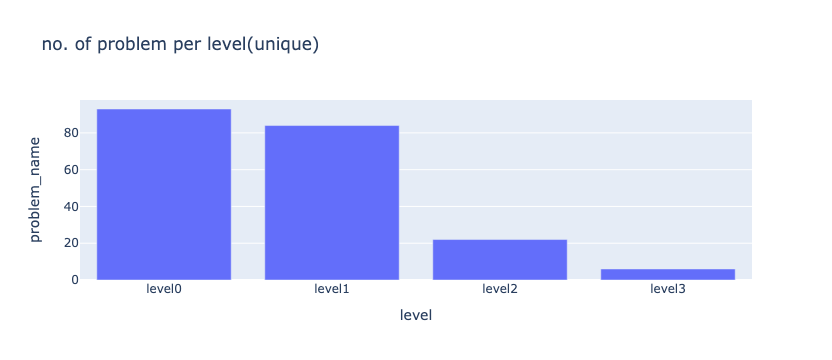

In [8]:
df = js_df[["level","problem_name"]].drop_duplicates().groupby("level").count()
fig = px.bar(df, x = df.index, y = "problem_name", title = "no. of problem per level(unique)")
fig.write_html("no_prob_per_level_drop_dup.html")
fig

In [48]:
df = js_df.groupby("level")[["problem_type"]].count()
fig = px.bar(df, x = df.index, y = "problem_type", title = "number of problem types per levels")
fig.write_html("no_type_per_level.html")
fig
df.to_dict()

{'problem_type': {'level0': 235, 'level1': 272, 'level2': 100, 'level3': 27}}

In [55]:
df = js_df.groupby("level")[["problem_type"]].count()
fig = px.pie(df, values = "problem_type",names = df.index, title = "number of problem types per levels: ratio")
fig.write_html("number_of_problem_types_per_levels:ratio.html")
df

,problem_type
level,
level0,235
level1,272
level2,100
level3,27


In [82]:
df = js_df[js_df["level"] == "level0"]["problem_type"].value_counts()
fig = px.pie(df, names = df.index, values = "problem_type", title = "problem types per levels: ratio")

fig
df.to_dict()

{'구현': 176, '기타': 45, '해시': 10, '완전탐색': 3, '정렬': 1}

In [87]:
# df = js_df[js_df["level"] == "level1"].groupby("problem_type").count().reset_index()
# fig = px.pie(df, names = "problem_type", values = "problem_name", title = "problem types per levels: ratio")
# fig.write_html("type_ratio_level1.html")
df = js_df[js_df["level"] == "level1"]["problem_type"].value_counts()
fig = px.pie(df, names = df.index, values = "problem_type", title = "problem types per levels: ratio")

fig
df.to_dict()

{'구현': 189,
 '기타': 21,
 '정렬': 18,
 '스택큐': 16,
 '해시': 10,
 '완전탐색': 8,
 '그리디': 8,
 '집합': 2}

In [88]:
df = js_df[js_df["level"] == "level2"].groupby("problem_type").count().reset_index()
fig = px.pie(df, names = "problem_type", values = "problem_name", title = "problem types per levels: ratio")
# fig.write_html("type_ratio_level2.html")
fig


df = js_df[js_df["level"] == "level2"]["problem_type"].value_counts()
fig = px.pie(df, names = df.index, values = "problem_type", title = "problem types per levels: ratio")

fig
df.to_dict()

{'구현': 36, '정렬': 26, '스택큐': 19, '해시': 9, '스택': 4, '투포인터': 4, '재귀': 2}


In [135]:
df = js_df[js_df["level"] == "level3"].groupby("problem_type").count().reset_index()
fig = px.pie(df, names = "problem_type", values = "problem_name", title = "problem types per levels: ratio")
fig.write_html("type_ratio_level3.html")
fig

df = js_df[js_df["level"] == "level3"]["problem_type"].value_counts()
fig = px.pie(df, names = df.index, values = "problem_type", title = "problem types per levels: ratio")

fig
df.to_dict()
df

DFSBFS    12
그래프        7
트리         5
구현         3
Name: problem_type, dtype: int64

In [95]:
js_df.groupby("level")[["function_method", "module"]].count()

,function_method,module
level,,
level0,235,0
level1,272,0
level2,100,0
level3,27,0


In [103]:
js_df.groupby("level")[["countmethod", "module"]].sum()

,countmethod,module
level,,
level0,288.0,0.0
level1,347.0,0.0
level2,129.0,0.0
level3,33.0,0.0


In [213]:
df = py_df.groupby(["level","function_method"])[["countmethod"]].sum()
df = df.reset_index().set_index("level").sort_values(by = "countmethod", ascending = False)

fig = px.bar(df, x='function_method', y='countmethod', color=df.index,
             color_discrete_sequence=px.colors.qualitative.G10,
             labels={'function_method': 'Function Method', 'countmethod': 'Count'})

fig.update_layout(
    title='레벨별 메소드 빈도수',
    xaxis_tickangle=-45  # 기울임 각도 설정
)

fig

df




js_level_method = df.groupby(['level','function_method'])['countmethod'].sum()
js_level_method

js_level_method_df = {}

for (level,function_method), value in js_level_method.items():
    if level not in js_level_method_df:
        js_level_method_df[level] = {}

    js_level_method_df[level][function_method] = value

js_level_method_df

{'level0': {'.append': 17.0,
  '.count': 8.0,
  '.find': 2.0,
  '.fromkeys': 1.0,
  '.index': 4.0,
  '.insert': 2.0,
  '.isdigit': 4.0,
  '.islower': 1.0,
  '.isupper': 1.0,
  '.items': 1.0,
  '.join': 10.0,
  '.lower': 3.0,
  '.pop': 1.0,
  '.remove': 1.0,
  '.replace': 5.0,
  '.reverse': 2.0,
  '.sort': 4.0,
  '.split': 2.0,
  '.startswith': 1.0,
  '.sub': 1.0,
  '.upper': 2.0,
  'abs': 1.0,
  'input': 2.0,
  'int': 17.0,
  'len': 21.0,
  'list': 2.0,
  'max': 6.0,
  'min': 1.0,
  'print': 2.0,
  'range': 20.0,
  're': 0.0,
  'set': 5.0,
  'sorted': 10.0,
  'str': 14.0,
  'sum': 6.0},
 'level1': {'.append': 30.0,
  '.compile': 3.0,
  '.count': 4.0,
  '.find': 2.0,
  '.findall': 2.0,
  '.gcd': 1.0,
  '.get': 2.0,
  '.index': 4.0,
  '.isdigit': 1.0,
  '.islower': 2.0,
  '.isqrt': 1.0,
  '.isupper': 1.0,
  '.items': 3.0,
  '.join': 6.0,
  '.keys': 1.0,
  '.lower': 4.0,
  '.pop': 2.0,
  '.remove': 1.0,
  '.replace': 3.0,
  '.sort': 6.0,
  '.split': 4.0,
  '.strip': 3.0,
  '.sub': 3.0,
  

---

---

In [334]:
js_df[["level","problem_name"]].drop_duplicates().groupby("level").count()


js_df.drop_duplicates().groupby("level")["problem_name"].count()

level
level0    235
level1    272
level2    100
level3     27
Name: problem_name, dtype: int64

In [243]:
df = js_df[["level","problem_name"]].drop_duplicates().groupby("level").count()
px.bar(df, x = df.index, y = "problem_name")

,file_name,level,year,company_name,problem_name,problem_type,function_method,countmethod,module,line_count,code
0,Lv1_0000_프로그래머스_대충만든자판_완전탐색_하연.js,level1,0000,프로그래머스,대충만든자판,완전탐색,.forEach,2.0,NaN,18,"function solution(keymap, targets) {\n const ..."
1,Lv1_0000_프로그래머스_대충만든자판_완전탐색_하연.js,level1,0000,프로그래머스,대충만든자판,완전탐색,.push,2.0,NaN,18,"function solution(keymap, targets) {\n const ..."
2,Lv1_0000_프로그래머스_문자열 내림차순으로 배치하기_구현_가은.js,level1,0000,프로그래머스,문자열 내림차순으로 배치하기,구현,.split,2.0,NaN,15,function solution(s) {\n let answer = s.split...
3,Lv1_0000_프로그래머스_문자열 내림차순으로 배치하기_구현_가은.js,level1,0000,프로그래머스,문자열 내림차순으로 배치하기,구현,.sort,2.0,NaN,15,function solution(s) {\n let answer = s.split...
4,Lv1_0000_프로그래머스_문자열 내림차순으로 배치하기_구현_가은.js,level1,0000,프로그래머스,문자열 내림차순으로 배치하기,구현,.join,2.0,NaN,15,function solution(s) {\n let answer = s.split...
...,...,...,...,...,...,...,...,...,...,...,...
629,Lv3_0000_프로그래머스_입국심사_구현_의호.js,level3,0000,프로그래머스,입국심사,구현,.floor,2.0,NaN,17,"function solution(n, times) {\n let answer = ..."
630,Lv3_0000_프로그래머스_입국심사_구현_의호.js,level3,0000,프로그래머스,입국심사,구현,.forEach,1.0,NaN,17,"function solution(n, times) {\n let answer = ..."
631,Lv3_0000_프로그래머스_네트워크_DFSBFS_의호.js,level3,0000,프로그래머스,네트워크,DFSBFS,.from,1.0,NaN,22,"function solution(n, computers) {\n let answe..."
632,Lv3_0000_프로그래머스_네트워크_DFSBFS_의호.js,level3,0000,프로그래머스,네트워크,DFSBFS,.push,2.0,NaN,22,"function solution(n, computers) {\n let answe..."


## bar - level 별 문제 수

{
    "problem_name":{
        "level0":77,
        "level1":71,
        "level2":20,
        "level3":6
    }
}


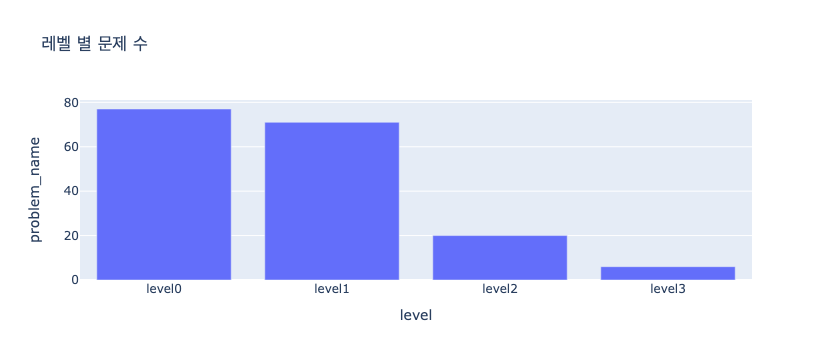

In [7]:
import re
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt



tmp_df = js_df.copy()
tmp_df["problem_name"] = tmp_df["problem_name"].apply(lambda x: x.strip().replace(" ",""))
tmp_df["problem_name"] = tmp_df["problem_name"].apply(lambda x: re.sub("\(.*?\)", "", x))
df = tmp_df.groupby("level")["problem_name"].nunique().reset_index().set_index("level")
# px.bar(df, x = df.index, y = "problem_name")
# df.to_json()
print(df.to_json(indent=4, force_ascii=False))
fig = px.bar(df , x= df.index, y= "problem_name", title = "레벨 별 문제 수")
fig.write_html("레벨_별_문제_수.html")
fig

## bar - level 별 problem type 개수

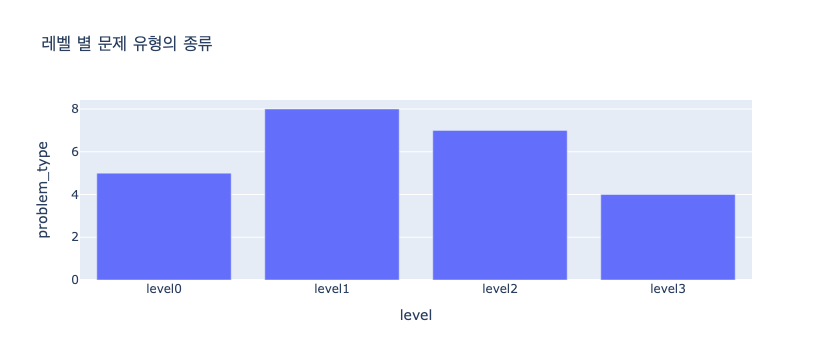

In [37]:
df = tmp_df.groupby("level")["problem_type"].nunique().to_frame()
px.bar(df, x = df.index, y = "problem_type", title = "레벨 별 문제 유형의 종류")


{
    "problem_type":{
        "level0":5,
        "level1":8,
        "level2":7,
        "level3":4
    }
}


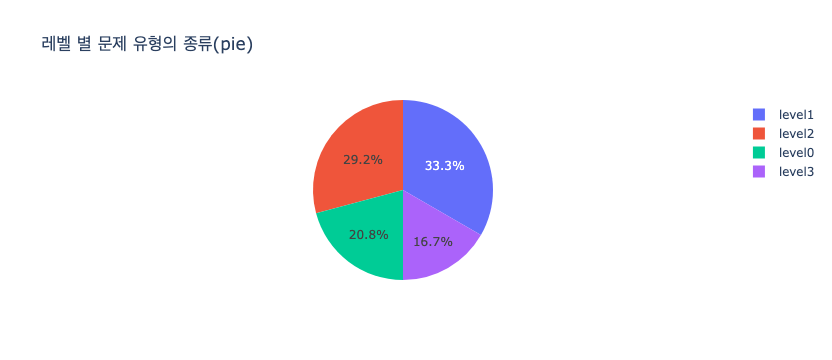

In [272]:
tmp_df = js_df.copy()
tmp_df["problem_type"] = tmp_df["problem_type"].apply(lambda x: x.strip().replace(" ",""))
tmp_df["problem_type"] = tmp_df["problem_type"].apply(lambda x: re.sub("\(.*?\)", "", x))
df = tmp_df.groupby("level")["problem_type"].nunique().reset_index().set_index("level")

# py_level_method = py_df.loc[js_df["problem_name"].drop_duplicates().index].groupby("level")["problem_name"].count()
# js_level_method = js_df.loc[js_df["problem_name"].drop_duplicates().index].groupby("level")["problem_name"].count()
# df.to_dict()
print(df.to_json(indent=4, force_ascii=False))
# py_level_method.to_dict()

fig1 = px.bar(df, x = df.index, y = "problem_type", title = "레벨 별 문제 유형의 종류")
fig1.write_html("레벨_별_문제_유형의_종류.html")
fig

fig2 = px.pie(df, names = df.index, values = "problem_type", title = "레벨 별 문제 유형의 종류(pie)")
fig2.write_html("레벨_별_문제_유형의_종류_pie.html")
fig2

In [40]:
tmp_df = js_df.copy()
tmp_df["file_name"] = tmp_df["file_name"].apply(lambda x: x.strip().replace(" ",""))
tmp_df["file_name"] = tmp_df["file_name"].apply(lambda x: re.sub("\(.*?\)", "", x))
tmp_df["problem_type"] = tmp_df["problem_type"].apply(lambda x: x.strip().replace(" ",""))
tmp_df["problem_type"] = tmp_df["problem_type"].apply(lambda x: re.sub("\(.*?\)", "", x))
df = tmp_df.groupby(["level","problem_type"])["file_name"].count()

js_level_ptype = tmp_df.groupby(["level","problem_type"])["file_name"].count()
# js_level_method = df.groupby(['level','function_method'])['countmethod'].sum()
# js_level_method

js_level_ptype_df = {}

for (level,problem_type), value in js_level_ptype.items():
    if level not in js_level_ptype_df:
        js_level_ptype_df[level] = {}

    js_level_ptype_df[level][problem_type] = value

print(js_level_ptype_df)

{'level0': {'구현': 176, '기타': 45, '완전탐색': 3, '정렬': 1, '해시': 10}, 'level1': {'구현': 189, '그리디': 8, '기타': 21, '스택큐': 16, '완전탐색': 8, '정렬': 18, '집합': 2, '해시': 10}, 'level2': {'구현': 36, '스택': 4, '스택큐': 19, '재귀': 2, '정렬': 26, '투포인터': 4, '해시': 9}, 'level3': {'DFSBFS': 12, '구현': 3, '그래프': 7, '트리': 5}}


In [60]:
## distinct

tmp_df = js_df.copy()
tmp_df["file_name"] = tmp_df["file_name"].apply(lambda x: x.strip().replace(" ",""))
tmp_df["file_name"] = tmp_df["file_name"].apply(lambda x: re.sub("\(.*?\)", "", x))
tmp_df["problem_type"] = tmp_df["problem_type"].apply(lambda x: x.strip().replace(" ",""))
tmp_df["problem_type"] = tmp_df["problem_type"].apply(lambda x: re.sub("\(.*?\)", "", x))
df = tmp_df.groupby(["level","problem_type"])["file_name"].nunique()

js_level_ptype = tmp_df.groupby(["level","problem_type"])["file_name"].nunique()
# js_level_method = df.groupby(['level','function_method'])['countmethod'].sum()
# js_level_method

js_level_ptype_df = {}

for (level,problem_type), value in js_level_ptype.items():
    if level not in js_level_ptype_df:
        js_level_ptype_df[level] = {}

    js_level_ptype_df[level][problem_type] = value

js_level_ptype_df


{'level0': {'구현': 90, '기타': 13, '완전탐색': 2, '정렬': 1, '해시': 3},
 'level1': {'구현': 69,
  '그리디': 3,
  '기타': 8,
  '스택큐': 6,
  '완전탐색': 3,
  '정렬': 6,
  '집합': 1,
  '해시': 5},
 'level2': {'구현': 8, '스택': 1, '스택큐': 6, '재귀': 1, '정렬': 6, '투포인터': 1, '해시': 2},
 'level3': {'DFSBFS': 3, '구현': 1, '그래프': 1, '트리': 1}}

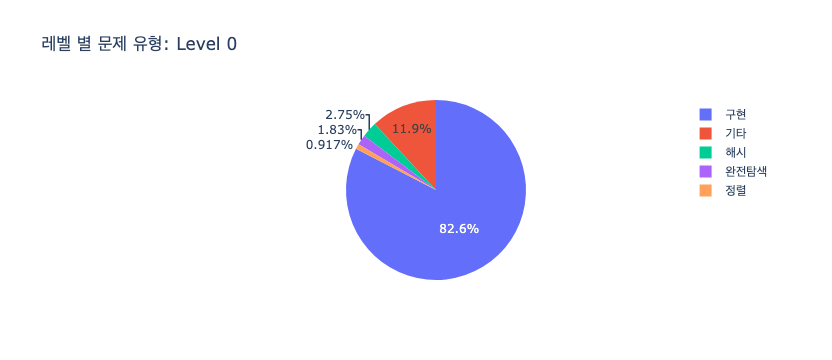

In [61]:
df = df.reset_index()
fig_df = df[df["level"] == "level0"]
fig = px.pie(fig_df, values = "file_name", names = "problem_type", title = "레벨 별 문제 유형: Level 0")
fig.write_html("레벨_문제_유형_level0.html")
fig

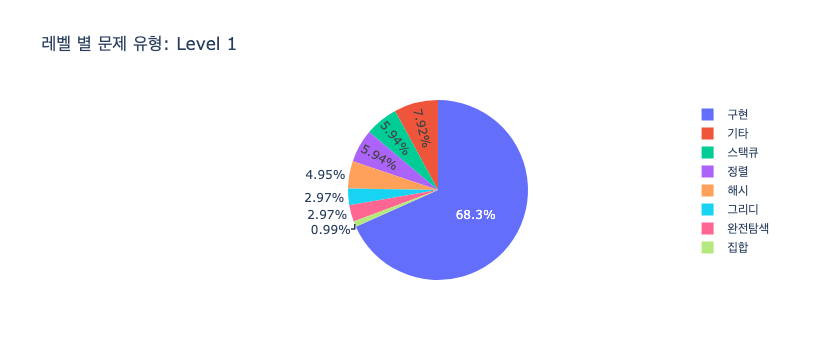

In [62]:
fig_df = df[df["level"] == "level1"]
fig = px.pie(fig_df, values = "file_name", names = "problem_type", title = "레벨 별 문제 유형: Level 1")
fig.write_html("레벨_문제_유형_level1.html")
fig

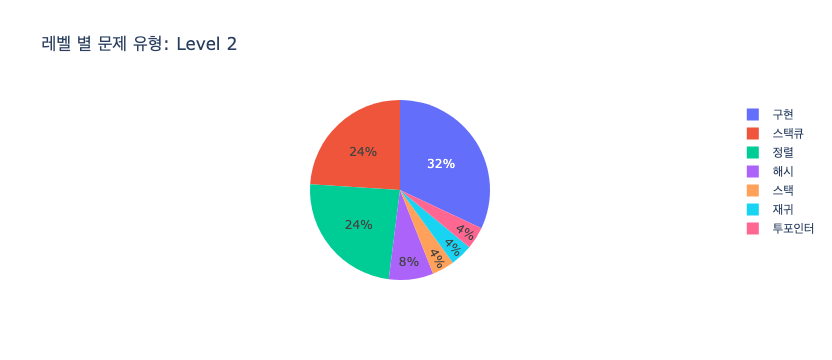

In [63]:
fig_df = df[df["level"] == "level2"]
fig = px.pie(fig_df, values = "file_name", names = "problem_type", title = "레벨 별 문제 유형: Level 2")
fig.write_html("레벨_문제_유형_level2.html")
fig

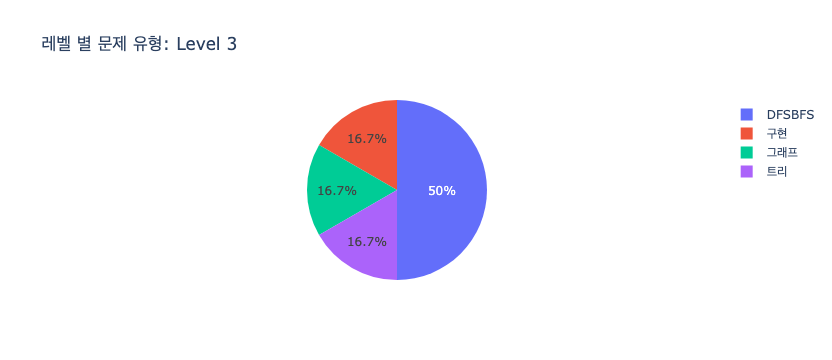

In [64]:
fig_df = df[df["level"] == "level3"]
fig = px.pie(fig_df, values = "file_name", names = "problem_type", title = "레벨 별 문제 유형: Level 3")
fig.write_html("레벨_문제_유형_level3.html")
fig

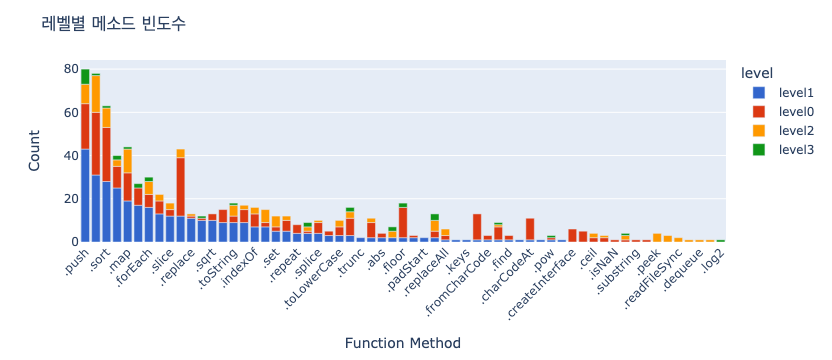

In [65]:
df = js_df.groupby(['level','function_method'])['countmethod'].sum()

# df = js_df.groupby(["level","function_method"])[["countmethod"]].sum()
df = df.reset_index().set_index("level").sort_values(by = "countmethod", ascending = False)

fig = px.bar(df, x='function_method', y='countmethod', color=df.index,
             color_discrete_sequence=px.colors.qualitative.G10,
             labels={'function_method': 'Function Method', 'countmethod': 'Count'})

fig.update_layout(
    title='레벨별 메소드 빈도수',
    xaxis_tickangle=-45  # 기울임 각도 설정
)



# cum bar

js_level_method = js_df.groupby(['level','function_method'])['countmethod'].sum()

js_level_method_df = {}

for (level,function_method), value in js_level_method.items():
    if level not in js_level_method_df:
        js_level_method_df[level] = {}
    js_level_method_df[level][function_method] = value

js_level_method_df
fig.write_html("레벨별 메소드 빈도수.html")
fig


---

# 레벨별 문제 수

In [7]:
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import re

In [245]:
# tmp_df = js_df.copy()
# tmp_df["problem_name"] = tmp_df["problem_name"].apply(lambda x: x.strip().replace(" ",""))
# tmp_df["problem_name"] = tmp_df["problem_name"].apply(lambda x: re.sub("\(.*?\)", "", x))
# df = tmp_df.groupby("level")["problem_name"].nunique()
# # px.bar(df, x = df.index, y = "problem_name")
# # df.to_json()
# # print(df.to_json(indent=4, force_ascii=False))
# level_problem_name = df.to_dict()
# level_problem_name

{'level0': 77, 'level1': 71, 'level2': 20, 'level3': 6}

In [31]:
tmp_df = py_df.copy()
tmp_df["problem_name"] = tmp_df["problem_name"].apply(lambda x: re.sub("\(1\)|\s", "", x))
df = tmp_df.groupby("level")["problem_name"].nunique()
level_problem_name = df.to_dict()
level_problem_name 

{'level0': 51, 'level1': 54, 'level2': 17, 'level3': 5}

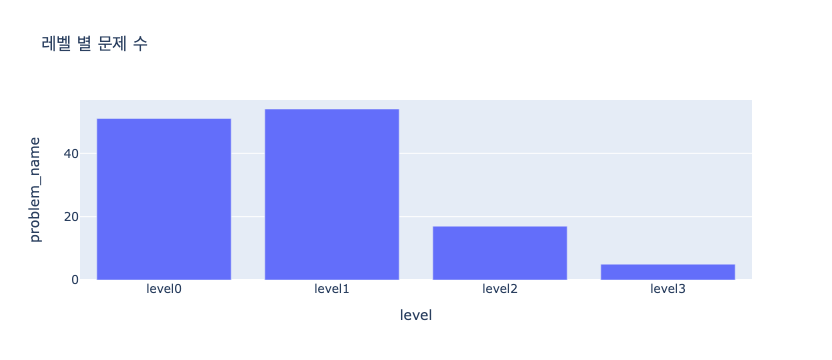

In [32]:
tmp_df = py_df.copy()
tmp_df["problem_name"] = tmp_df["problem_name"].apply(lambda x: re.sub("\(1\)|\s", "", x))

df = tmp_df.groupby("level")["problem_name"].nunique().reset_index().set_index("level")
fig = px.bar(df , x= df.index, y= "problem_name", title = "레벨 별 문제 수")
fig.write_html("레벨_별_문제_수.html")
fig

# 레벨별 문제 유형 개수

In [249]:
# tmp_df = js_df.copy()
# tmp_df["problem_type"] = tmp_df["problem_type"].apply(lambda x: x.strip().replace(" ",""))
# tmp_df["problem_type"] = tmp_df["problem_type"].apply(lambda x: re.sub("\(.*?\)", "", x))
# df = tmp_df.groupby("level")["problem_type"].nunique()

# # py_level_method = py_df.loc[js_df["problem_name"].drop_duplicates().index].groupby("level")["problem_name"].count()
# # js_level_method = js_df.loc[js_df["problem_name"].drop_duplicates().index].groupby("level")["problem_name"].count()
# # df.to_dict()
# # print(df.to_json(indent=4, force_ascii=False))
# # py_level_method.to_dict()
# level_problem_type = df.to_dict()
# level_problem_type

{'level0': 5, 'level1': 8, 'level2': 7, 'level3': 4}

In [33]:
tmp_df = py_df.copy()
tmp_df["problem_type"] = tmp_df["problem_type"].apply(lambda x: re.sub("\(1\)|\s", "", x))
df = tmp_df.groupby("level")["problem_type"].nunique()

level_problem_type = df.to_dict()
level_problem_type

{'level0': 2, 'level1': 8, 'level2': 4, 'level3': 3}

In [34]:
# tmp_df = js_df.copy()
# tmp_df["problem_type"] = tmp_df["problem_type"].apply(lambda x: re.sub("\(1\)|\s", "", x))
# df = tmp_df.groupby("level")["problem_type"].nunique().to_frame()
# px.bar(df, x = df.index, y = "problem_type", title = "레벨 별 문제 유형의 종류")

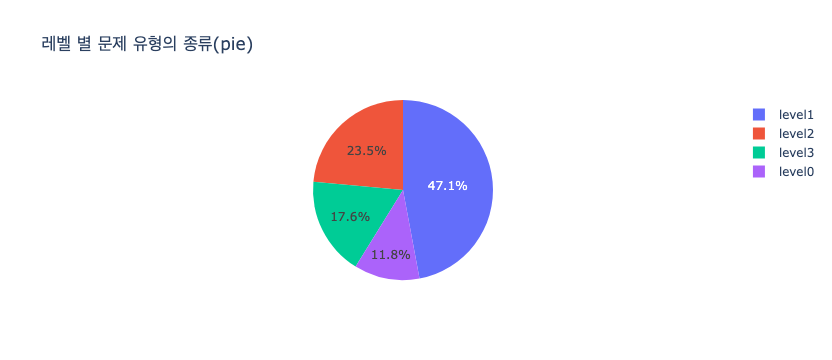

In [35]:
tmp_df = py_df.copy()
tmp_df["problem_type"] = tmp_df["problem_type"].apply(lambda x: re.sub("\(1\)|\s", "", x))
df = tmp_df.groupby("level")["problem_type"].nunique().reset_index().set_index("level")

fig1 = px.bar(df, x = df.index, y = "problem_type", title = "레벨 별 문제 유형의 종류")
fig1.write_html("레벨_별_문제_유형의_종류.html")
fig

fig2 = px.pie(df, names = df.index, values = "problem_type", title = "레벨 별 문제 유형의 종류(pie)")
fig2.write_html("레벨_별_문제_유형의_종류_pie.html")
fig2

# 레벨 별 메소드 이용 수

In [36]:
# tmp_df = js_df.copy()
# tmp_df["file_name"] = tmp_df["file_name"].apply(lambda x: x.strip().replace(" ",""))
# tmp_df["file_name"] = tmp_df["file_name"].apply(lambda x: re.sub("\(.*?\)", "", x))
# tmp_df["problem_type"] = tmp_df["problem_type"].apply(lambda x: x.strip().replace(" ",""))
# tmp_df["problem_type"] = tmp_df["problem_type"].apply(lambda x: re.sub("\(.*?\)", "", x))
# df = tmp_df.groupby(["level","problem_type"])["file_name"].nunique()

# df = tmp_df.groupby(["level","problem_type"])["file_name"].nunique()
# # js_level_method = df.groupby(['level','function_method'])['countmethod'].sum()
# # js_level_method

# level_ptype_dict = {}

# for (level,problem_type), value in df.items():
    
#     if level not in level_ptype_dict:
#         level_ptype_dict[level] = {}

#     level_ptype_dict[level][problem_type] = value

# level_ptype_dict

In [37]:
tmp_df = py_df.copy()
tmp_df["file_name"] = tmp_df["file_name"].apply(lambda x: re.sub("\s", "", x))
tmp_df["problem_type"] = tmp_df["problem_type"].apply(lambda x: re.sub("\(1\)|\s", "", x))
df = tmp_df.groupby(["level","problem_type"])["file_name"].nunique()


level_ptype_dict = {}

for (level,problem_type), value in df.items():
    
    if level not in level_ptype_dict:
        level_ptype_dict[level] = {}

    level_ptype_dict[level][problem_type] = value

level_ptype_dict

{'level0': {'구현': 78, '기타': 1},
 'level1': {'': 1,
  '구현': 75,
  '그리디': 2,
  '기타': 2,
  '비트연산': 1,
  '스택큐': 2,
  '완전탐색': 3,
  '해시': 2},
 'level2': {'DFSBFS': 2, '구현': 6, '스택큐': 9, '완전탐색': 1},
 'level3': {'DFSBFS': 2, '기타': 2, '해시': 1}}

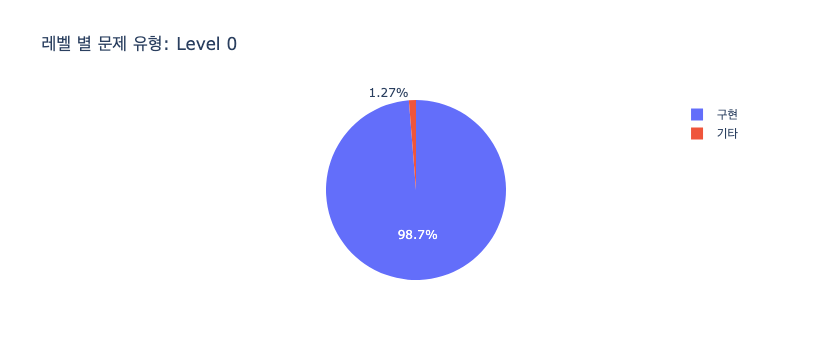

In [38]:
tmp_df = py_df.copy()
tmp_df["file_name"] = tmp_df["file_name"].apply(lambda x: re.sub("\s", "", x))
tmp_df["problem_type"] = tmp_df["problem_type"].apply(lambda x: re.sub("\(1\)|\s", "", x))
df = tmp_df.groupby(["level","problem_type"])["file_name"].nunique().reset_index()

fig_df = df[df["level"] == "level0"]
fig = px.pie(fig_df, values = "file_name", names = "problem_type", title = "레벨 별 문제 유형: Level 0")
fig.write_html("레벨_문제_유형_level0.html")
fig

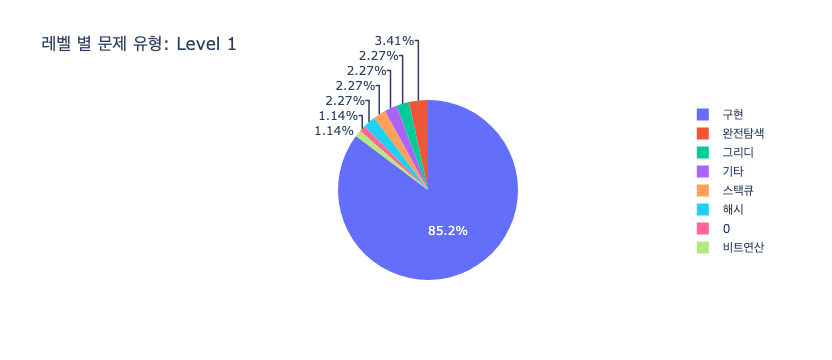

In [39]:
tmp_df = py_df.copy()
tmp_df["file_name"] = tmp_df["file_name"].apply(lambda x: re.sub("\s", "", x))
tmp_df["problem_type"] = tmp_df["problem_type"].apply(lambda x: re.sub("\(1\)|\s", "", x))
df = tmp_df.groupby(["level","problem_type"])["file_name"].nunique().reset_index()

fig_df = df[df["level"] == "level1"]
fig = px.pie(fig_df, values = "file_name", names = "problem_type", title = "레벨 별 문제 유형: Level 1")
fig.write_html("레벨_문제_유형_level1.html")
fig

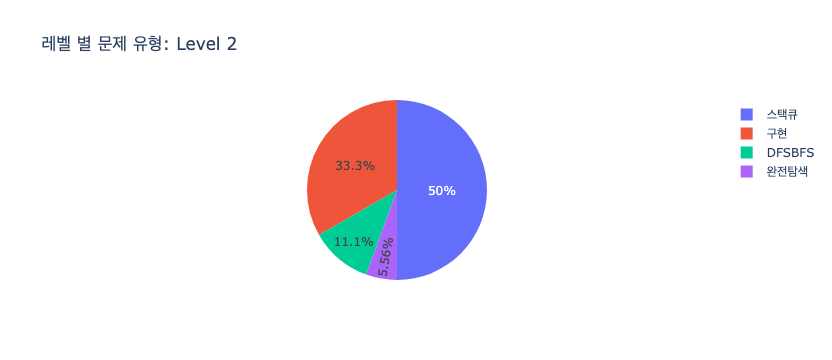

In [40]:
tmp_df = py_df.copy()
tmp_df["file_name"] = tmp_df["file_name"].apply(lambda x: re.sub("\s", "", x))
tmp_df["problem_type"] = tmp_df["problem_type"].apply(lambda x: re.sub("\(1\)|\s", "", x))
df = tmp_df.groupby(["level","problem_type"])["file_name"].nunique().reset_index()

fig_df = df[df["level"] == "level2"]
fig = px.pie(fig_df, values = "file_name", names = "problem_type", title = "레벨 별 문제 유형: Level 2")
fig.write_html("레벨_문제_유형_level2.html")
fig

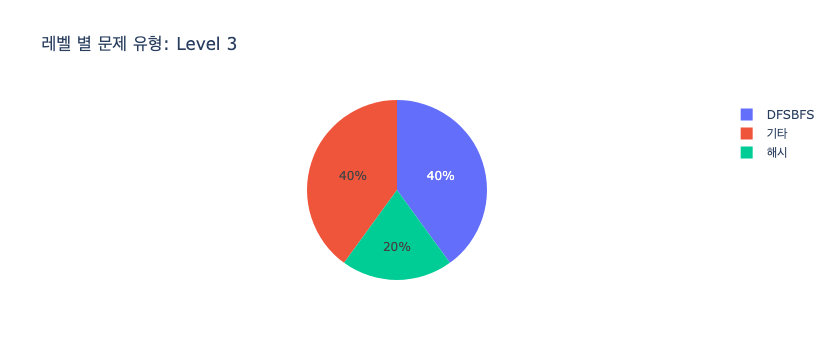

In [41]:
tmp_df = py_df.copy()
tmp_df["file_name"] = tmp_df["file_name"].apply(lambda x: re.sub("\s", "", x))
tmp_df["problem_type"] = tmp_df["problem_type"].apply(lambda x: re.sub("\(1\)|\s", "", x))
df = tmp_df.groupby(["level","problem_type"])["file_name"].nunique().reset_index()

fig_df = df[df["level"] == "level3"]
fig = px.pie(fig_df, values = "file_name", names = "problem_type", title = "레벨 별 문제 유형: Level 3")
fig.write_html("레벨_문제_유형_level3.html")
fig

# 메소드 이용 누적 수

In [42]:
df = py_df.groupby("function_method")["countmethod"].sum().sort_values(ascending = False)
# df = df.reset_index().set_index("function_method")
count_method_sort = df.to_dict()
count_method_sort

{'range': 90.0,
 'len': 82.0,
 '.append': 70.0,
 'int': 40.0,
 'str': 33.0,
 'sorted': 24.0,
 'sum': 22.0,
 'ord': 18.0,
 'max': 18.0,
 '.join': 17.0,
 'set': 15.0,
 '.count': 14.0,
 'list': 12.0,
 '.pop': 11.0,
 '.sort': 11.0,
 '.index': 9.0,
 '.popleft': 9.0,
 '.lower': 8.0,
 '.replace': 8.0,
 '.split': 8.0,
 'print': 6.0,
 'min': 6.0,
 'chr': 6.0,
 '.upper': 5.0,
 'map': 5.0,
 'zip': 5.0,
 '.isdigit': 5.0,
 '.items': 5.0,
 '.find': 4.0,
 'abs': 4.0,
 '.sub': 4.0,
 '.strip': 3.0,
 '.compile': 3.0,
 'bin': 3.0,
 '.islower': 3.0,
 'input': 3.0,
 '.remove': 2.0,
 'enumerate': 2.0,
 '.isupper': 2.0,
 '.insert': 2.0,
 '.get': 2.0,
 '.reverse': 2.0,
 '.findall': 2.0,
 '.isqrt': 1.0,
 '.gcd': 1.0,
 '.fromkeys': 1.0,
 'reversed': 1.0,
 '.zfill': 1.0,
 '.keys': 1.0,
 'divmod': 1.0,
 'dict': 1.0,
 '.values': 1.0,
 '.startswith': 1.0,
 'math': 0.0,
 'deque': 0.0,
 're': 0.0,
 'combinations': 0.0,
 'collections': 0.0,
 'ceil': 0.0,
 'itertools': 0.0}

In [43]:
# cum bar
df = py_df.groupby(['level','function_method'])['countmethod'].sum()
level_per_method = {}

for (level,function_method), value in df.items():
    if level not in level_per_method:
        level_per_method[level] = {}
    level_per_method[level][function_method] = value

level_per_method

{'level0': {'.append': 17.0,
  '.count': 8.0,
  '.find': 2.0,
  '.fromkeys': 1.0,
  '.index': 4.0,
  '.insert': 2.0,
  '.isdigit': 4.0,
  '.islower': 1.0,
  '.isupper': 1.0,
  '.items': 1.0,
  '.join': 10.0,
  '.lower': 3.0,
  '.pop': 1.0,
  '.remove': 1.0,
  '.replace': 5.0,
  '.reverse': 2.0,
  '.sort': 4.0,
  '.split': 2.0,
  '.startswith': 1.0,
  '.sub': 1.0,
  '.upper': 2.0,
  'abs': 1.0,
  'input': 2.0,
  'int': 17.0,
  'len': 21.0,
  'list': 2.0,
  'max': 6.0,
  'min': 1.0,
  'print': 2.0,
  'range': 20.0,
  're': 0.0,
  'set': 5.0,
  'sorted': 10.0,
  'str': 14.0,
  'sum': 6.0},
 'level1': {'.append': 30.0,
  '.compile': 3.0,
  '.count': 4.0,
  '.find': 2.0,
  '.findall': 2.0,
  '.gcd': 1.0,
  '.get': 2.0,
  '.index': 4.0,
  '.isdigit': 1.0,
  '.islower': 2.0,
  '.isqrt': 1.0,
  '.isupper': 1.0,
  '.items': 3.0,
  '.join': 6.0,
  '.keys': 1.0,
  '.lower': 4.0,
  '.pop': 2.0,
  '.remove': 1.0,
  '.replace': 3.0,
  '.sort': 6.0,
  '.split': 4.0,
  '.strip': 3.0,
  '.sub': 3.0,
  

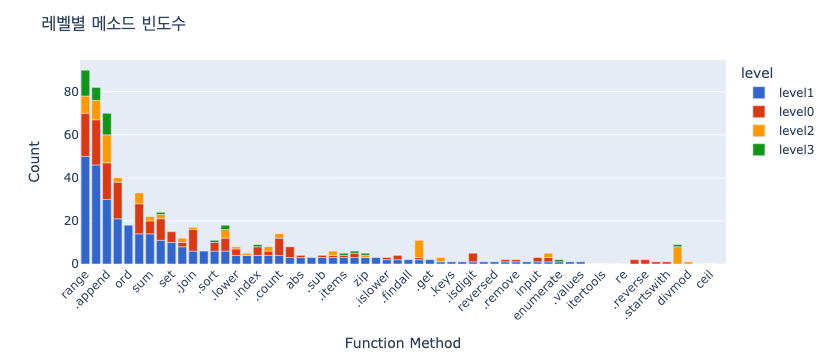

In [44]:
df = py_df.groupby(['level','function_method'])['countmethod'].sum()
df = df.reset_index().set_index("level").sort_values(by = "countmethod", ascending = False)

fig = px.bar(df, x='function_method', y='countmethod', color=df.index,
             color_discrete_sequence=px.colors.qualitative.G10,
             labels={'function_method': 'Function Method', 'countmethod': 'Count'})
fig.update_layout(
    title='레벨별 메소드 빈도수',
    xaxis_tickangle=-45  # 기울임 각도 설정
)

fig.write_html("레벨별 메소드 빈도수.html")
fig


In [30]:
js_dict={
    "level_problem_name" : level_problem_name,
    "level_problem_type" : level_problem_type,
    "level_problem_type_ratio" : level_ptype_dict,
    "function_method_sort" : count_method_sort,
    "level_per_function_method":level_per_method
}

js_dict

{'level_problem_name': {'level0': 80, 'level1': 71, 'level2': 20, 'level3': 6},
 'level_problem_type': {'level0': 5, 'level1': 8, 'level2': 7, 'level3': 4},
 'level_problem_type_ratio': {'level0': {'구현': 90,
   '기타': 13,
   '완전탐색': 2,
   '정렬': 1,
   '해시': 3},
  'level1': {'구현': 69,
   '그리디': 3,
   '기타': 8,
   '스택큐': 6,
   '완전탐색': 3,
   '정렬': 6,
   '집합': 1,
   '해시': 5},
  'level2': {'구현': 8, '스택': 1, '스택큐': 6, '재귀': 1, '정렬': 6, '투포인터': 1, '해시': 2},
  'level3': {'DFSBFS': 3, '구현': 1, '그래프': 1, '트리': 1}},
 'function_method_sort': {'.push': 80.0,
  '.split': 78.0,
  '.sort': 63.0,
  '.map': 44.0,
  '.join': 43.0,
  '.filter': 40.0,
  '.forEach': 30.0,
  'parseInt': 27.0,
  '.reduce': 22.0,
  '.slice': 18.0,
  '.toString': 18.0,
  '.floor': 18.0,
  '.min': 17.0,
  '.indexOf': 16.0,
  '.max': 16.0,
  '.includes': 15.0,
  '.get': 15.0,
  '.replace': 13.0,
  '.sqrt': 13.0,
  '.pop': 13.0,
  '.on': 13.0,
  '.reverse': 12.0,
  '.toUpperCase': 12.0,
  '.set': 12.0,
  '.charCodeAt': 11.0,
  '.log'

In [46]:
py_dict={    
    "level_problem_name" : level_problem_name,
    "level_problem_type" : level_problem_type,
    "level_problem_type_ratio" : level_ptype_dict,
    "function_method_sort" : count_method_sort,
    "level_per_function_method":level_per_method
}

py_dict

{'level_problem_name': {'level0': 51, 'level1': 54, 'level2': 17, 'level3': 5},
 'level_problem_type': {'level0': 2, 'level1': 8, 'level2': 4, 'level3': 3},
 'level_problem_type_ratio': {'level0': {'구현': 78, '기타': 1},
  'level1': {'': 1,
   '구현': 75,
   '그리디': 2,
   '기타': 2,
   '비트연산': 1,
   '스택큐': 2,
   '완전탐색': 3,
   '해시': 2},
  'level2': {'DFSBFS': 2, '구현': 6, '스택큐': 9, '완전탐색': 1},
  'level3': {'DFSBFS': 2, '기타': 2, '해시': 1}},
 'function_method_sort': {'range': 90.0,
  'len': 82.0,
  '.append': 70.0,
  'int': 40.0,
  'str': 33.0,
  'sorted': 24.0,
  'sum': 22.0,
  'ord': 18.0,
  'max': 18.0,
  '.join': 17.0,
  'set': 15.0,
  '.count': 14.0,
  'list': 12.0,
  '.pop': 11.0,
  '.sort': 11.0,
  '.index': 9.0,
  '.popleft': 9.0,
  '.lower': 8.0,
  '.replace': 8.0,
  '.split': 8.0,
  'print': 6.0,
  'min': 6.0,
  'chr': 6.0,
  '.upper': 5.0,
  'map': 5.0,
  'zip': 5.0,
  '.isdigit': 5.0,
  '.items': 5.0,
  '.find': 4.0,
  'abs': 4.0,
  '.sub': 4.0,
  '.strip': 3.0,
  '.compile': 3.0,
  'bi

In [47]:
import json
print(json.dumps(py_dict, indent=4, ensure_ascii = False))
print(json.dumps(js_dict, indent=4, ensure_ascii = False))


{
    "level_problem_name": {
        "level0": 51,
        "level1": 54,
        "level2": 17,
        "level3": 5
    },
    "level_problem_type": {
        "level0": 2,
        "level1": 8,
        "level2": 4,
        "level3": 3
    },
    "level_problem_type_ratio": {
        "level0": {
            "구현": 78,
            "기타": 1
        },
        "level1": {
            "": 1,
            "구현": 75,
            "그리디": 2,
            "기타": 2,
            "비트연산": 1,
            "스택큐": 2,
            "완전탐색": 3,
            "해시": 2
        },
        "level2": {
            "DFSBFS": 2,
            "구현": 6,
            "스택큐": 9,
            "완전탐색": 1
        },
        "level3": {
            "DFSBFS": 2,
            "기타": 2,
            "해시": 1
        }
    },
    "function_method_sort": {
        "range": 90.0,
        "len": 82.0,
        ".append": 70.0,
        "int": 40.0,
        "str": 33.0,
        "sorted": 24.0,
        "sum": 22.0,
        "ord": 18.0,
        "max": 18.

In [49]:
all_dict = {
"py": {
    "level_problem_name": {
        "level0": 51,
        "level1": 54,
        "level2": 17,
        "level3": 5
    },
    "level_problem_type": {
        "level0": 2,
        "level1": 8,
        "level2": 4,
        "level3": 3
    },
    "level_problem_type_ratio": {
        "level0": {
            "구현": 78,
            "기타": 1
        },
        "level1": {
            "": 1,
            "구현": 75,
            "그리디": 2,
            "기타": 2,
            "비트연산": 1,
            "스택큐": 2,
            "완전탐색": 3,
            "해시": 2
        },
        "level2": {
            "DFSBFS": 2,
            "구현": 6,
            "스택큐": 9,
            "완전탐색": 1
        },
        "level3": {
            "DFSBFS": 2,
            "기타": 2,
            "해시": 1
        }
    },
    "function_method_sort": {
        "range": 90.0,
        "len": 82.0,
        ".append": 70.0,
        "int": 40.0,
        "str": 33.0,
        "sorted": 24.0,
        "sum": 22.0,
        "ord": 18.0,
        "max": 18.0,
        ".join": 17.0,
        "set": 15.0,
        ".count": 14.0,
        "list": 12.0,
        ".pop": 11.0,
        ".sort": 11.0,
        ".index": 9.0,
        ".popleft": 9.0,
        ".lower": 8.0,
        ".replace": 8.0,
        ".split": 8.0,
        "print": 6.0,
        "min": 6.0,
        "chr": 6.0,
        ".upper": 5.0,
        "map": 5.0,
        "zip": 5.0,
        ".isdigit": 5.0,
        ".items": 5.0,
        ".find": 4.0,
        "abs": 4.0,
        ".sub": 4.0,
        ".strip": 3.0,
        ".compile": 3.0,
        "bin": 3.0,
        ".islower": 3.0,
        "input": 3.0,
        ".remove": 2.0,
        "enumerate": 2.0,
        ".isupper": 2.0,
        ".insert": 2.0,
        ".get": 2.0,
        ".reverse": 2.0,
        ".findall": 2.0,
        ".isqrt": 1.0,
        ".gcd": 1.0,
        ".fromkeys": 1.0,
        "reversed": 1.0,
        ".zfill": 1.0,
        ".keys": 1.0,
        "divmod": 1.0,
        "dict": 1.0,
        ".values": 1.0,
        ".startswith": 1.0,
        "math": 0.0,
        "deque": 0.0,
        "re": 0.0,
        "combinations": 0.0,
        "collections": 0.0,
        "ceil": 0.0,
        "itertools": 0.0
    },
    "level_per_function_method": {
        "level0": {
            ".append": 17.0,
            ".count": 8.0,
            ".find": 2.0,
            ".fromkeys": 1.0,
            ".index": 4.0,
            ".insert": 2.0,
            ".isdigit": 4.0,
            ".islower": 1.0,
            ".isupper": 1.0,
            ".items": 1.0,
            ".join": 10.0,
            ".lower": 3.0,
            ".pop": 1.0,
            ".remove": 1.0,
            ".replace": 5.0,
            ".reverse": 2.0,
            ".sort": 4.0,
            ".split": 2.0,
            ".startswith": 1.0,
            ".sub": 1.0,
            ".upper": 2.0,
            "abs": 1.0,
            "input": 2.0,
            "int": 17.0,
            "len": 21.0,
            "list": 2.0,
            "max": 6.0,
            "min": 1.0,
            "print": 2.0,
            "range": 20.0,
            "re": 0.0,
            "set": 5.0,
            "sorted": 10.0,
            "str": 14.0,
            "sum": 6.0
        },
        "level1": {
            ".append": 30.0,
            ".compile": 3.0,
            ".count": 4.0,
            ".find": 2.0,
            ".findall": 2.0,
            ".gcd": 1.0,
            ".get": 2.0,
            ".index": 4.0,
            ".isdigit": 1.0,
            ".islower": 2.0,
            ".isqrt": 1.0,
            ".isupper": 1.0,
            ".items": 3.0,
            ".join": 6.0,
            ".keys": 1.0,
            ".lower": 4.0,
            ".pop": 2.0,
            ".remove": 1.0,
            ".replace": 3.0,
            ".sort": 6.0,
            ".split": 4.0,
            ".strip": 3.0,
            ".sub": 3.0,
            ".upper": 1.0,
            ".values": 1.0,
            ".zfill": 1.0,
            "abs": 3.0,
            "bin": 1.0,
            "chr": 6.0,
            "combinations": 0.0,
            "dict": 1.0,
            "enumerate": 1.0,
            "input": 1.0,
            "int": 21.0,
            "itertools": 0.0,
            "len": 46.0,
            "list": 8.0,
            "map": 4.0,
            "math": 0.0,
            "max": 6.0,
            "min": 3.0,
            "ord": 18.0,
            "print": 3.0,
            "range": 50.0,
            "re": 0.0,
            "reversed": 1.0,
            "set": 10.0,
            "sorted": 11.0,
            "str": 14.0,
            "sum": 14.0,
            "zip": 3.0
        },
        "level2": {
            ".append": 13.0,
            ".count": 2.0,
            ".join": 1.0,
            ".lower": 1.0,
            ".pop": 8.0,
            ".popleft": 8.0,
            ".split": 2.0,
            ".upper": 2.0,
            "bin": 2.0,
            "ceil": 0.0,
            "collections": 0.0,
            "deque": 0.0,
            "divmod": 1.0,
            "int": 2.0,
            "len": 9.0,
            "list": 2.0,
            "map": 1.0,
            "math": 0.0,
            "max": 4.0,
            "min": 2.0,
            "range": 8.0,
            "sorted": 2.0,
            "str": 5.0,
            "sum": 2.0,
            "zip": 1.0
        },
        "level3": {
            ".append": 10.0,
            ".index": 1.0,
            ".items": 1.0,
            ".popleft": 1.0,
            ".sort": 1.0,
            "collections": 0.0,
            "deque": 0.0,
            "enumerate": 1.0,
            "len": 6.0,
            "max": 2.0,
            "print": 1.0,
            "range": 12.0,
            "sorted": 1.0,
            "zip": 1.0
        }
    }
},
"js" : {
    "level_problem_name": {
        "level0": 80,
        "level1": 71,
        "level2": 20,
        "level3": 6
    },
    "level_problem_type": {
        "level0": 5,
        "level1": 8,
        "level2": 7,
        "level3": 4
    },
    "level_problem_type_ratio": {
        "level0": {
            "구현": 90,
            "기타": 13,
            "완전탐색": 2,
            "정렬": 1,
            "해시": 3
        },
        "level1": {
            "구현": 69,
            "그리디": 3,
            "기타": 8,
            "스택큐": 6,
            "완전탐색": 3,
            "정렬": 6,
            "집합": 1,
            "해시": 5
        },
        "level2": {
            "구현": 8,
            "스택": 1,
            "스택큐": 6,
            "재귀": 1,
            "정렬": 6,
            "투포인터": 1,
            "해시": 2
        },
        "level3": {
            "DFSBFS": 3,
            "구현": 1,
            "그래프": 1,
            "트리": 1
        }
    },
    "function_method_sort": {
        ".push": 80.0,
        ".split": 78.0,
        ".sort": 63.0,
        ".map": 44.0,
        ".join": 43.0,
        ".filter": 40.0,
        ".forEach": 30.0,
        "parseInt": 27.0,
        ".reduce": 22.0,
        ".slice": 18.0,
        ".toString": 18.0,
        ".floor": 18.0,
        ".min": 17.0,
        ".indexOf": 16.0,
        ".max": 16.0,
        ".includes": 15.0,
        ".get": 15.0,
        ".replace": 13.0,
        ".sqrt": 13.0,
        ".pop": 13.0,
        ".on": 13.0,
        ".reverse": 12.0,
        ".toUpperCase": 12.0,
        ".set": 12.0,
        ".charCodeAt": 11.0,
        ".log": 11.0,
        ".toLowerCase": 10.0,
        ".splice": 10.0,
        ".shift": 9.0,
        ".from": 9.0,
        ".repeat": 8.0,
        ".fill": 7.0,
        ".createInterface": 6.0,
        ".replaceAll": 6.0,
        ".match": 5.0,
        ".test": 5.0,
        ".abs": 4.0,
        ".peek": 4.0,
        ".ceil": 4.0,
        ".unshift": 4.0,
        ".find": 3.0,
        ".add": 3.0,
        ".isInteger": 3.0,
        ".fromCharCode": 3.0,
        ".pow": 3.0,
        ".trim": 3.0,
        ".trunc": 2.0,
        ".padStart": 2.0,
        ".readFileSync": 2.0,
        ".setEncoding": 1.0,
        ".round": 1.0,
        ".substr": 1.0,
        ".substring": 1.0,
        ".log2": 1.0,
        ".keys": 1.0,
        ".isNaN": 1.0,
        ".every": 1.0,
        ".enqueue": 1.0,
        ".dequeue": 1.0,
        ".values": 1.0,
        ".Array": 1.0
    },
    "level_per_function_method": {
        "level0": {
            ".abs": 2.0,
            ".add": 2.0,
            ".ceil": 2.0,
            ".charCodeAt": 10.0,
            ".createInterface": 6.0,
            ".filter": 10.0,
            ".find": 2.0,
            ".floor": 14.0,
            ".forEach": 6.0,
            ".from": 6.0,
            ".fromCharCode": 2.0,
            ".get": 2.0,
            ".includes": 6.0,
            ".indexOf": 6.0,
            ".isInteger": 1.0,
            ".isNaN": 1.0,
            ".join": 27.0,
            ".log": 7.0,
            ".map": 13.0,
            ".match": 5.0,
            ".max": 8.0,
            ".min": 6.0,
            ".on": 12.0,
            ".pop": 3.0,
            ".pow": 1.0,
            ".push": 21.0,
            ".reduce": 6.0,
            ".repeat": 4.0,
            ".replace": 1.0,
            ".replaceAll": 2.0,
            ".reverse": 1.0,
            ".round": 1.0,
            ".set": 2.0,
            ".shift": 1.0,
            ".slice": 3.0,
            ".sort": 25.0,
            ".splice": 5.0,
            ".split": 29.0,
            ".sqrt": 3.0,
            ".substring": 1.0,
            ".test": 2.0,
            ".toLowerCase": 4.0,
            ".toString": 3.0,
            ".toUpperCase": 5.0,
            ".unshift": 1.0,
            "parseInt": 8.0
        },
        "level1": {
            ".Array": 1.0,
            ".abs": 2.0,
            ".charCodeAt": 1.0,
            ".every": 1.0,
            ".fill": 2.0,
            ".filter": 25.0,
            ".find": 1.0,
            ".floor": 2.0,
            ".forEach": 16.0,
            ".from": 1.0,
            ".fromCharCode": 1.0,
            ".get": 7.0,
            ".includes": 9.0,
            ".indexOf": 7.0,
            ".isInteger": 2.0,
            ".join": 12.0,
            ".keys": 1.0,
            ".log": 2.0,
            ".map": 19.0,
            ".max": 3.0,
            ".min": 9.0,
            ".on": 1.0,
            ".padStart": 2.0,
            ".pop": 2.0,
            ".pow": 1.0,
            ".push": 43.0,
            ".reduce": 13.0,
            ".repeat": 4.0,
            ".replace": 11.0,
            ".replaceAll": 1.0,
            ".reverse": 10.0,
            ".set": 5.0,
            ".setEncoding": 1.0,
            ".shift": 4.0,
            ".slice": 12.0,
            ".sort": 28.0,
            ".splice": 4.0,
            ".split": 31.0,
            ".sqrt": 10.0,
            ".substr": 1.0,
            ".test": 3.0,
            ".toLowerCase": 3.0,
            ".toString": 9.0,
            ".toUpperCase": 5.0,
            ".trunc": 2.0,
            "parseInt": 17.0
        },
        "level2": {
            ".add": 1.0,
            ".ceil": 2.0,
            ".dequeue": 1.0,
            ".enqueue": 1.0,
            ".fill": 3.0,
            ".filter": 3.0,
            ".forEach": 6.0,
            ".from": 1.0,
            ".get": 6.0,
            ".indexOf": 3.0,
            ".join": 4.0,
            ".log": 2.0,
            ".map": 11.0,
            ".max": 3.0,
            ".min": 2.0,
            ".peek": 4.0,
            ".pop": 5.0,
            ".push": 9.0,
            ".readFileSync": 2.0,
            ".reduce": 3.0,
            ".replace": 1.0,
            ".replaceAll": 3.0,
            ".set": 5.0,
            ".shift": 2.0,
            ".slice": 3.0,
            ".sort": 9.0,
            ".splice": 1.0,
            ".split": 17.0,
            ".toLowerCase": 3.0,
            ".toString": 5.0,
            ".toUpperCase": 2.0,
            ".trim": 3.0,
            ".unshift": 2.0,
            ".values": 1.0
        },
        "level3": {
            ".fill": 2.0,
            ".filter": 2.0,
            ".floor": 2.0,
            ".forEach": 2.0,
            ".from": 1.0,
            ".log2": 1.0,
            ".map": 1.0,
            ".max": 2.0,
            ".pop": 3.0,
            ".pow": 1.0,
            ".push": 7.0,
            ".reverse": 1.0,
            ".shift": 2.0,
            ".sort": 1.0,
            ".split": 1.0,
            ".toString": 1.0,
            ".unshift": 1.0,
            "parseInt": 2.0
        }
    }
}
}

import json

print(json.dumps(all_dict, indent=4, ensure_ascii = False))


{
    "py": {
        "level_problem_name": {
            "level0": 51,
            "level1": 54,
            "level2": 17,
            "level3": 5
        },
        "level_problem_type": {
            "level0": 2,
            "level1": 8,
            "level2": 4,
            "level3": 3
        },
        "level_problem_type_ratio": {
            "level0": {
                "구현": 78,
                "기타": 1
            },
            "level1": {
                "": 1,
                "구현": 75,
                "그리디": 2,
                "기타": 2,
                "비트연산": 1,
                "스택큐": 2,
                "완전탐색": 3,
                "해시": 2
            },
            "level2": {
                "DFSBFS": 2,
                "구현": 6,
                "스택큐": 9,
                "완전탐색": 1
            },
            "level3": {
                "DFSBFS": 2,
                "기타": 2,
                "해시": 1
            }
        },
        "function_method_sort": {
            "range": 90